# Solving TSP using Binary PSO (BPSO)

In [27]:
import numpy as np
import pandas as pd
from collections import defaultdict
from haversine import haversine
import networkx as nx
import matplotlib.pyplot as plt
import pyswarms as ps

### Define the TSP

In [28]:
# Define latitude and longitude for twenty major U.S. cities
cities = {
    'New York City': (40.72, -74.00),
    'Philadelphia': (39.95, -75.17),       
    'Baltimore': (39.28, -76.62),
    'Charlotte': (35.23, -80.85),
    'Memphis': (35.12, -89.97),
    'Jacksonville': (30.32, -81.70),
    'Houston': (29.77, -95.38),
    'Austin': (30.27, -97.77),
    'San Antonio': (29.53, -98.47),
    'Fort Worth': (32.75, -97.33),
    'Dallas': (32.78, -96.80),
    'San Diego': (32.78, -117.15),
    'Los Angeles': (34.05, -118.25),
    'San Jose': (37.30, -121.87),
    'San Francisco': (37.78, -122.42),    
    'Indianapolis': (39.78, -86.15),
    'Phoenix': (33.45, -112.07),       
    'Columbus': (39.98, -82.98), 
    'Chicago': (41.88, -87.63),
    'Detroit': (42.33, -83.05)
}

# Create a haversine distance matrix based on latitude-longitude coordinates
distance_matrix = defaultdict(dict)
for ka, va in cities.items():
    for kb, vb in cities.items():
        distance_matrix[ka][kb] = 0.0 if kb == ka else haversine((va[0], va[1]), (vb[0], vb[1])) 

# Convert distance diccionary into a dataframe        
distances = pd.DataFrame(distance_matrix)
city_names=list(distances.columns)
distance=distances.values      

### Visualize the cities

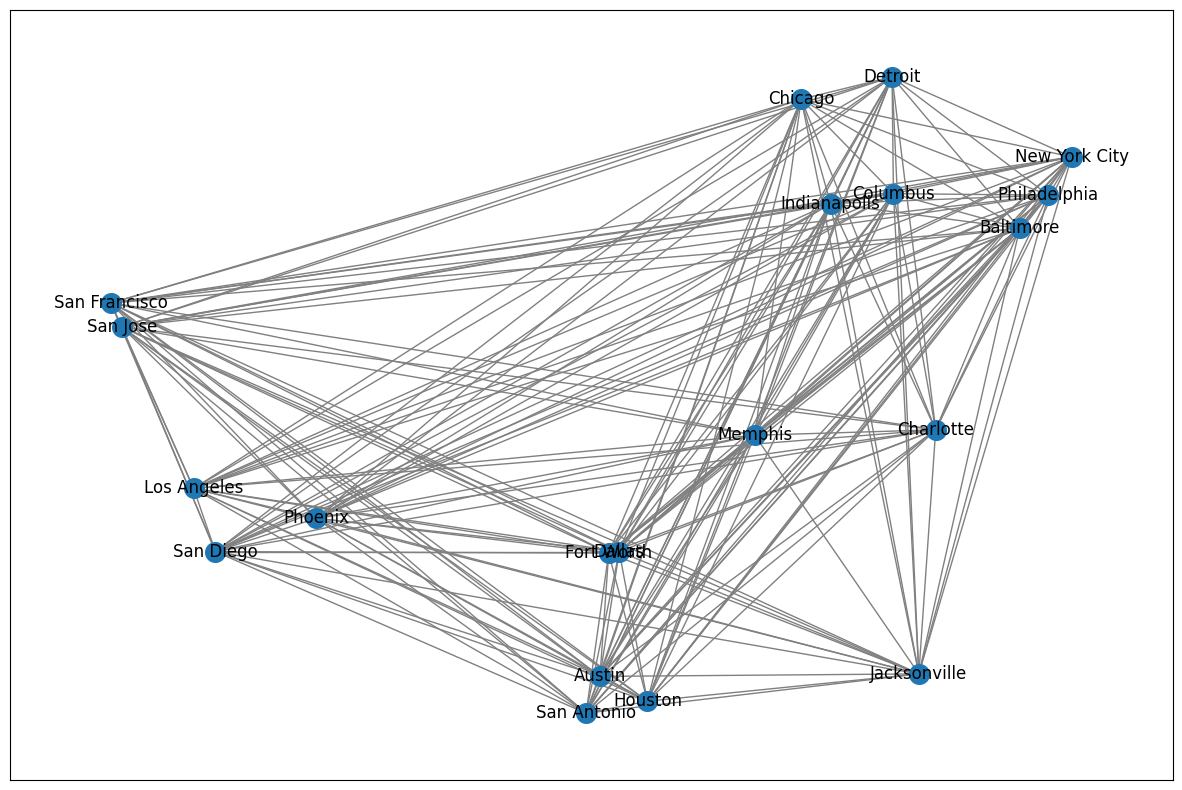

In [29]:
# Create a graph
G=nx.Graph()

for ka, va in cities.items():
    for kb, vb in cities.items():
        G.add_weighted_edges_from({(ka,kb, distance_matrix[ka][kb])})
        G.remove_edges_from(nx.selfloop_edges(G))
        
fig, ax = plt.subplots(figsize=(15,10))

# Reverse lat and long for correct visualization
reversed_dict = {key: value[::-1] for key, value in cities.items()}

# Create an independent shallow copy of the graph and attributes
H = G.copy()
 
# Draw the network
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,
    with_labels=True,
    edge_color="gray",
    node_size=200,
    width=1,
)

plt.show()

### Define fitness function

In [30]:
# Define the TSP problem as a permutation optimization problem
n_cities = len(city_names)
bounds = (np.zeros(n_cities), np.ones(n_cities)*(n_cities-1)) # Integer bounds

# Define the TSP distance function
def tsp_distance(position, distance):
    # Convert the permutation to a TSP tour
    tour = np.argsort(position)
    # Compute the total distance of the tour
    total_distance = distance[0, tour[0]] # Add distance from New York City to first city
    for i in range(n_cities-1):
        total_distance += distance[tour[i], tour[i+1]]
    total_distance += distance[tour[-1], 0] # Add distance from last city back to New York City
    return total_distance

# Define the objective function
def tsp_cost(x, distance):
    n_particles = x.shape[0]
    cost=0
    cost = [tsp_distance(x[i], distance) for i in range(n_particles)]
    return cost

### Define the solver and use it to solve the TSP

In [31]:
# Instantiate the PSO optimizer
options = {'c1': 2.05, 'c2': 1.5, 'w': 0.79, 'k': 10, 'p': 2}
optimizer = ps.discrete.BinaryPSO(n_particles=50, dimensions=n_cities, options=options)

# Solve the problem
cost, solution = optimizer.optimize(tsp_cost, iters=150, verbose=True, distance=distance)

# Convert the best solution to a TSP tour
tour = np.argsort(solution)
city_names_tour = [city_names[i] for i in tour]

2023-04-30 09:12:36,670 - pyswarms.discrete.binary - INFO - Optimize for 150 iters with {'c1': 2.05, 'c2': 1.5, 'w': 0.79, 'k': 10, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|150/150, best_cost=1.28e+4
2023-04-30 09:12:37,625 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 12781.891754118898, best pos: [0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1]


### Print the route and the length

In [32]:
Route = " → ".join(city_names_tour)
print("Route:", Route)
print("Route length:", np.round(cost, 3))

Route: New York City → Columbus → Indianapolis → Memphis → San Francisco → San Jose → Los Angeles → San Diego → Phoenix → Dallas → Fort Worth → San Antonio → Austin → Houston → Jacksonville → Charlotte → Baltimore → Philadelphia → Chicago → Detroit
Route length: 12781.892


### Visualize the route

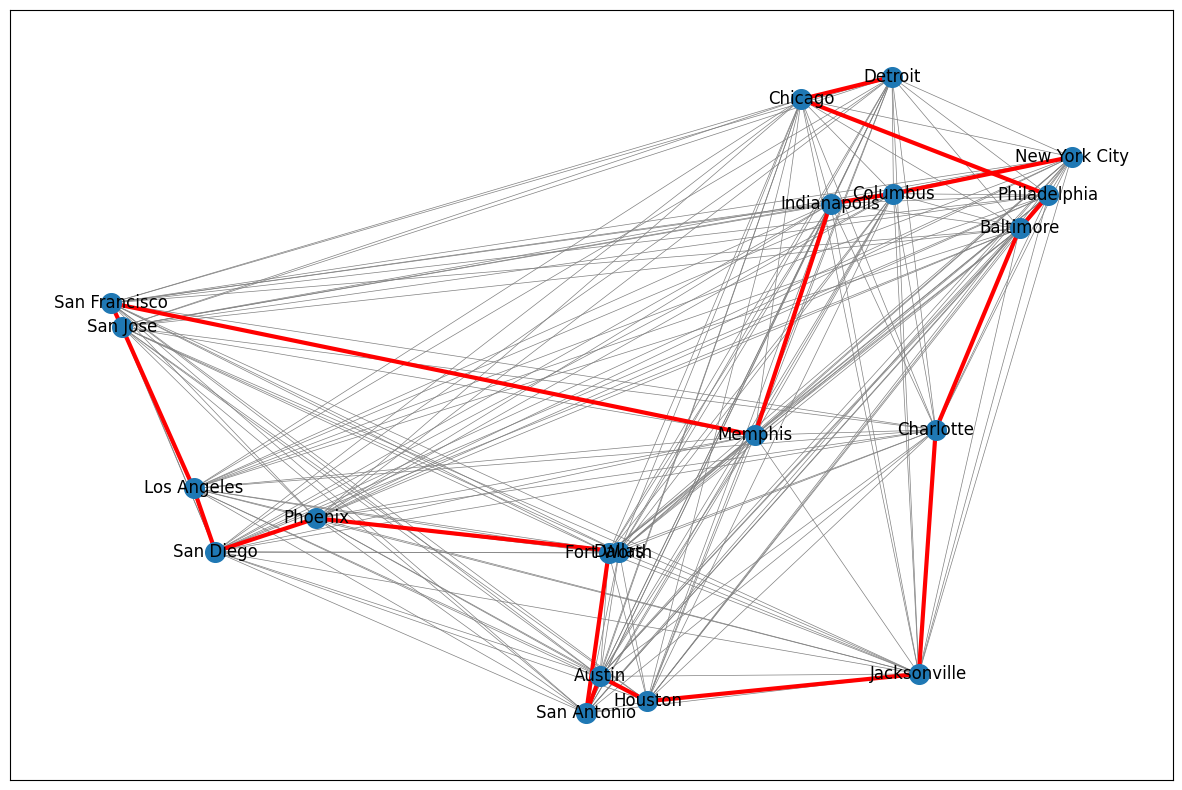

In [33]:
fig, ax = plt.subplots(figsize=(15,10))

# Create an independent shallow copy of the graph and attributes
H = G.copy()

# Reverse lat and long for correct visualization
reversed_dict = {key: value[::-1] for key, value in cities.items()}

# Create edge list
edge_list =list(nx.utils.pairwise(city_names_tour))

# Draw closest edges on each node only
nx.draw_networkx_edges(H, pos=reversed_dict, edge_color="gray", width=0.5)

# Draw the route
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,
    with_labels=True,
    edgelist=edge_list,
    edge_color="red",
    node_size=200,
    width=3,
)

plt.show()
# plt.savefig('CH09_F15_TSP_Soln.png', format='png', dpi=300)